In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import sklearn

In [16]:
path = "/mnt/c/Users/olivi/OneDrive - Amherst College/6 Summer 2025/surface-detection"

##### 128x2 Variable Threshold Sequence Dataset

In [ ]:
thresholds = [
    [25, 26, 27, 28, 28],
    [21, 17, 21, 20, 21],
    [19, 14, 22, 25, 25],
    [25, 22, 27, 24, 27],
    [24, 22, 24, 26, 25]
]

counts = [
    [156, 145, 154, 160, 142], # User 1
    [149, 130, 156, 136, 120], # User 2
    [142, 103, 142, 152, 137], # User 3
    [145, 144, 159, 149, 142], # User 4
    [137, 138, 136, 124, 134]  # User 5
]

locations = ["A", "B", "C", "D", "E"]
labels = ["User 1", "User 2", "User 3", "User 4", "User 5"]

In [ ]:
def dataset_barplot(split, title=""):
    colors = plt.get_cmap('Set3').colors

    split = np.array(split)
    x = np.arange(5)

    fig, ax = plt.subplots()
    bottom = np.zeros(5)
    for i, row in enumerate(split):
        ax.bar(x, row, bottom=bottom, label=labels[i], color = colors[i])
        bottom += row 

    ax.set_xticks(x)
    ax.set_xticklabels(locations)
    ax.set_xlabel("Location")
    ax.set_ylabel("Number of Sequences")

    # ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.12), ncol=5)
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
    ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
    
    plt.title(title)
    plt.show()

In [ ]:
# counts: stacked barplot
dataset_barplot(counts)

# thresholds: line plot
colors = plt.get_cmap('Set3').colors
for i in range(5):
    plt.plot(locations, thresholds[i], label=labels[i], color = colors[i])
plt.legend()
plt.xlabel("Location")
plt.ylabel("Peak Acceleration Threshold")
plt.show()

##### Single sequence (normalized)

In [ ]:
def sequence_norm(user=1, location="A", instance=1):
    A1 = pd.read_csv(f"{path}/sequences/varied-threshold/User{user}_Location{location}_Normal_{instance}.dat", header=None)
    plt.plot(list(range(1, 129)), A1[0] / A1[0].max(), label='acceleration')
    plt.plot(list(range(1, 129)), A1[1] / A1[1].max(), color='red', label="Gyroscope")
    plt.title("Normalized Accelerometer, Gyroscope for Sequence")
    plt.legend()
    plt.show()

sequence_norm()

##### Dataset split visualization

In [ ]:
# load dataset partitions, filenames
lines = []
with open(f"{path}/sequences/filenames.txt", 'r') as filenames:
    lines = filenames.readlines()

In [ ]:
def split_barplot(filepath, title):
    indices = []
    with open(filepath) as f:
        indices = f.readlines()
    counts = [[0 for i in range(0, 5)] for j in range(0, 5)] # initialize to zeros
    for i in indices:
        user = 0
        match lines[int(i.strip())-1].split('_')[0]:
            case "User1" : user = 0
            case "User2" : user = 1
            case "User3" : user = 2
            case "User4" : user = 3
            case "User5" : user = 4
        match lines[int(i.strip())-1].split('_')[1]:
            case "LocationA" : counts[user][0] += 1
            case "LocationB" : counts[user][1] += 1
            case "LocationC" : counts[user][2] += 1
            case "LocationD" : counts[user][3] += 1
            case "LocationE" : counts[user][4] += 1
    dataset_barplot(counts, title)

In [ ]:
split_barplot(f"{path}/logs/dataset-info/u5out_train.txt", "Training Set")
split_barplot(f"{path}/logs/dataset-info/u5out_val.txt", "Validation Set")
split_barplot(f"{path}/logs/dataset-info/u5out_test.txt", "Test Set")

##### Confusion heatmap

In [ ]:
nn = "ver5b"
trial = 2
train = pd.read_csv(f"{path}/logs/accuracy/{nn}_accuracy_train_{trial}.txt")
val = pd.read_csv(f"{path}/logs/accuracy/{nn}_accuracy_val_{trial}.txt")
test = pd.read_csv(f"{path}/logs/accuracy/{nn}_accuracy_test_{trial}.txt")

In [ ]:
# confusion matrix heatmap, normalized over true (rows)
def confusion_heatmap(set=train, fsetname="train", setname="Training"):
    sklearn.metrics.ConfusionMatrixDisplay.from_predictions(set["True"], set["Predicted"], 
                                                            cmap='cividis', 
                                                            display_labels=["A", "B", "C", "D", "E"],
                                                            normalize="true")
    plt.xlabel("Predicted location")
    plt.ylabel("True location")
    plt.title(f"{nn.capitalize()} Predictions on {setname} Set")
    plt.savefig(f"{path}/figures/nn-results/{nn}_confusion_{fsetname}_{trial}.png")
    # plt.show()

In [ ]:
confusion_heatmap(train, "train", "Training")
confusion_heatmap(val, "val", "Validation")
confusion_heatmap(test, "test", "Test")

##### Accuracy, Precision and Recall Comparisons

In [19]:
versions = ["ver2", "ver3", "ver4", "ver5a", "ver5b"]
sets = ["train", "val", "test"]
metrics = ["accuracy", "precision", "recall"]
trials = [1, 2]

In [21]:
def comparison(metric="accuracy", trial=1):
    x = ["A", "B", "C", "D", "E"]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
    for k in range(5):
        model = versions[k]
        y = []
        if model == "ver2" and trial == 1:
            continue
        for i in range(3):
            guesses = pd.read_csv(f"{path}/logs/accuracy/{model}_accuracy_{sets[i]}_{trial}.txt")
            confusion = sklearn.metrics.confusion_matrix(guesses["True"], guesses["Predicted"])
            if metric == "precision":
                # precision = TP / (TP + FP)
                y.append([confusion[j][j] / np.sum(confusion[:, j]) for j in range(5)])
            elif metric == "recall":
                # recall = TP / (TP + FN)
                y.append([confusion[j][j] / np.sum(confusion[j]) for j in range(5)])
            else:
                # accuracy = true predictions / all predictions
                y.append([np.trace(confusion) / np.sum(confusion) for j in range(5)])

        cmap = mpl.colormaps.get_cmap('cividis')
        colors = cmap(np.linspace(0, 1, len(versions)))

        ax1.plot(x, y[0], label=model, color=colors[k])
        ax2.plot(x, y[1], label=model, color=colors[k])
        ax3.plot(x, y[2], label=model, color=colors[k])

        if trial == 1:
            trialname = "Even"
        else:
            trialname = "U5 Separate"
    
    ax1.set_ylabel(metric.capitalize())
    ax2.set_xlabel("Location")
    ax2.set_title(f"{metric.capitalize()} on Training, Validation, and Test Sets ({trialname})")
    ax3.legend(loc='center right', bbox_to_anchor=(1.34, 0.5))
    plt.tight_layout()
    plt.show()

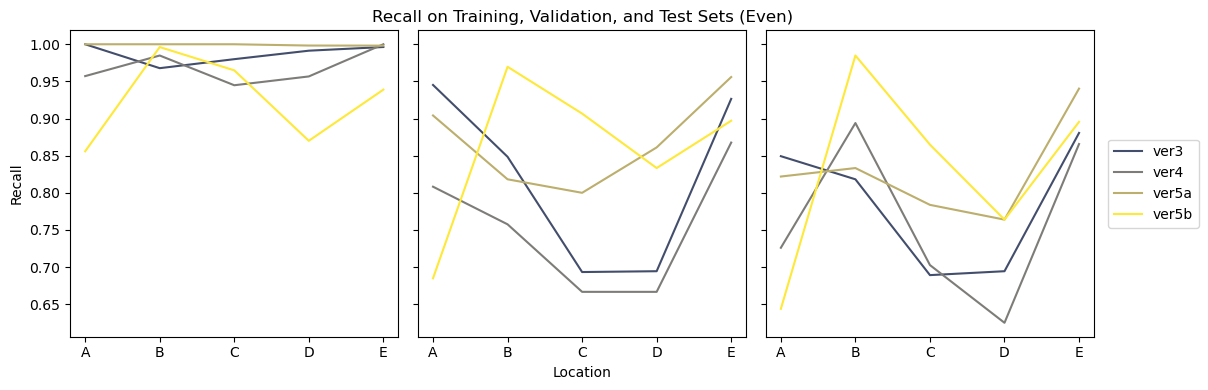

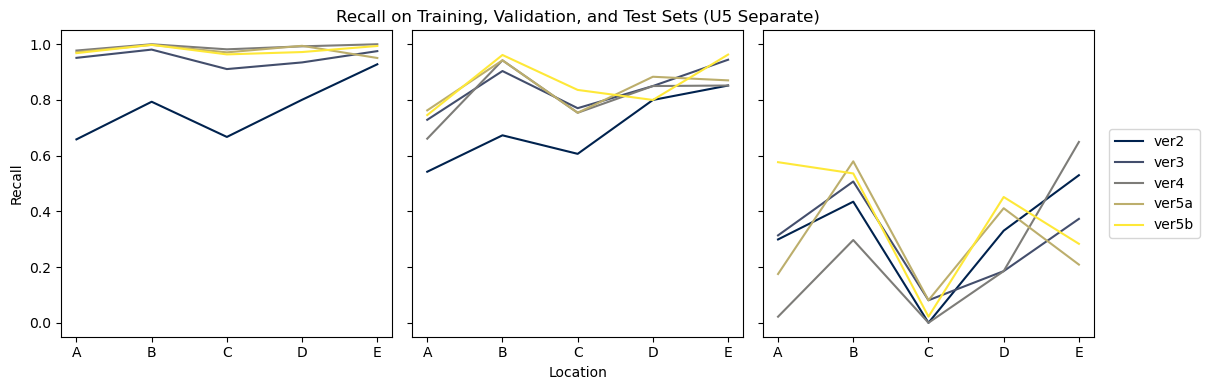

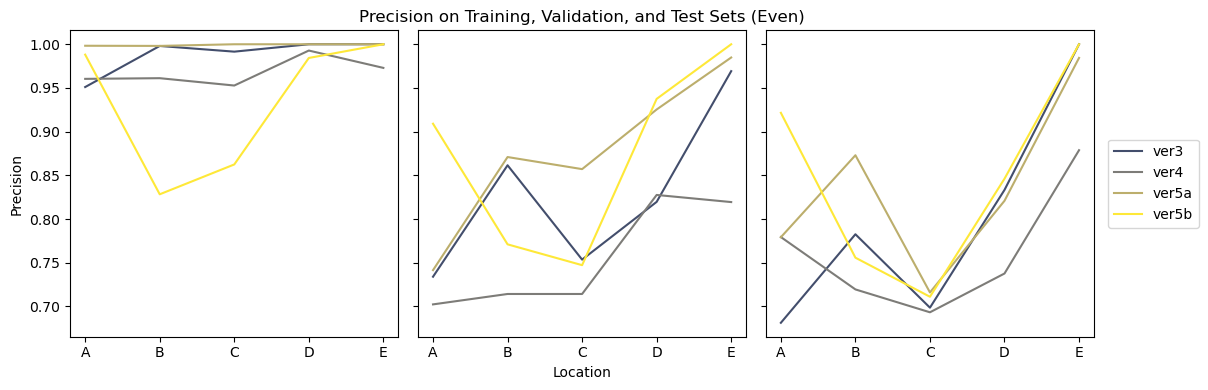

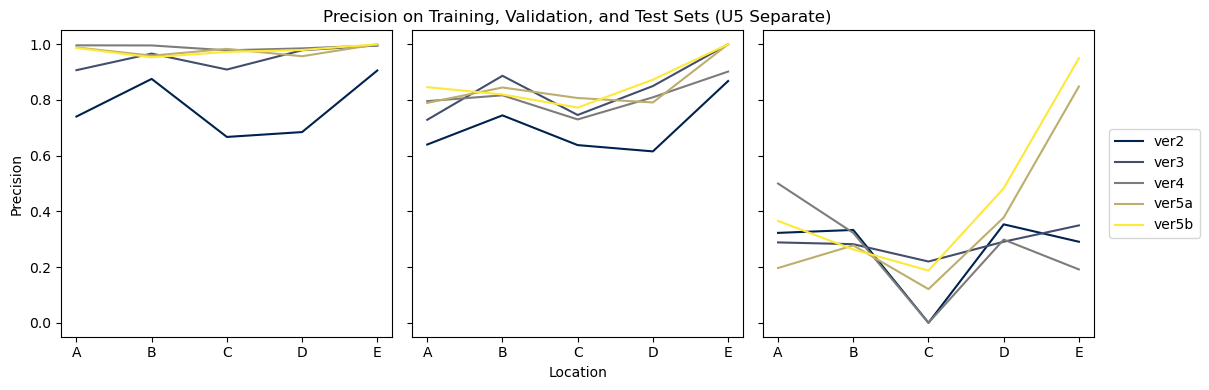

In [22]:
comparison("recall", 1)
comparison("recall", 2)
comparison("precision", 1)
comparison("precision", 2)